## ３章のkeras版


### 前準備

In [1]:
import numpy as np
import random
from IPython.display import Image
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

# keras用のパッケージをインポート
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


### 環境の引用
３章で使われているゲームは、4x4のマス目に
- A: エージェント
- W: 壁
- -: ピット
- +: ゴール

を配置し、エージェントが壁を避けて最短でゴールに到着させるゲームです。

３章の図3.1からゲームの画面を引用します。

<img src="images/fig3.1.png" width="300"/>

### ゲームの引用
Deep Reinforcement Learning in ActionのgithubサイトからGridBoard.py, Gridworld.pyを引用し、scriptディレクトリに配置しました。

In [2]:
from script.Gridworld  import *

## 強化学習の手順
バリュー関数は、以下のように定義します。

$$
V_{\pi}(s) = \Sigma_{i=1}^t w_i R_i = w_1 R_1 + w_2 R_2 + \dots+ w_t R_t
$$


同様にアクション・バリュー関数 $Q_{\pi}(s, a)$ は、以下ように更新されます。

$$
Q_{\pi}(S_{t+1}, A_{t}) = Q_{\pi}(S_t, A_t) + \alpha \left [ R_{t+1} + \gamma \, max \, Q(S_{t+1}, a) - Q(S_t, A_t) \right ]
$$

ここで、各変数は以下のように定義されています。
- $Q_{\pi}(S_{t+1}, A_{t}) $: 更新されたQ値
- $Q_{\pi}(S_t, A_t)$: 現在のQ値
- $\alpha$: ステップサイズ
- $\gamma$: 減衰ファクタ
- $max \, Q(S_{t+1}, a) $: すべてのアクションでの最大のQ値

### Qネットワークの更新
Qネットワークの更新は、以下のフローで行います。

In [3]:
%%bash
dot -Tpng -Gdpi=200 models/fig_3_3.dot> images/fig_3_3.png

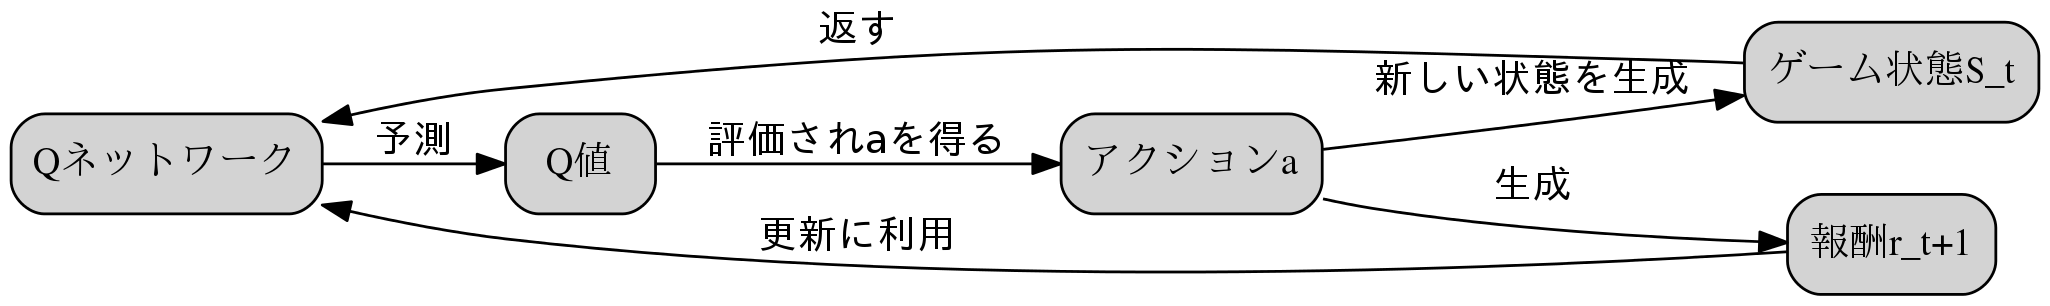

In [4]:
Image("images/fig_3_3.png")

### ゲームの動き


In [5]:
game = Gridworld(size=4, mode='static')
game.display()

array([[u'+', u'-', u' ', u'P'],
       [u' ', u'W', u' ', u' '],
       [u' ', u' ', u' ', u' '],
       [u' ', u' ', u' ', u' ']], 
      dtype='<U2')

In [6]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([[u'+', u'-', u' ', u' '],
       [u' ', u'W', u' ', u' '],
       [u' ', u' ', u'P', u' '],
       [u' ', u' ', u' ', u' ']], 
      dtype='<U2')

In [7]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

render_npでは、Wall, Player, Goal, Pitの配置が1で表された4x4の配列がそれぞれ返されます。

図3.6から配置のイメージを引用します。

<img src="images/fig3.6.png" width="300" />


### ニューラルネットモデル


In [8]:
D_in, H1, H2, D_out = 64, 150, 100, 4
learning_rate = 1e-3

def createModel(learning_rate=learning_rate):
    model = Sequential()
    model.add(Dense(H1, activation='relu', input_dim=D_in))
    model.add(Dense(H2, activation='relu'))
    model.add(Dense(D_out))
    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
# ゲームのシニュレーションをする環境を準備
class SimulationEnv(object):
    def __init__(self, model, game, epsilon, depsilon=0.05, gamma=0.9):
        self.model = model
        self.game = game
        self.epsilon = epsilon
        self.depsilon = depsilon
        self.gamma = gamma
        # おそらくデータが極端にスパースになるのを防ぐためではないかと推測
        self.noise_rate = 1.0/10.0
        # 出力層の次元
        self.D_out = int(self.model.weights[-1].shape[0])
    
    # 現在のゲームの状態を返す
    def state(self):
        state = self.game.board.render_np().reshape(1,64) + np.random.rand(1,64)*self.noise_rate
        return state
    
    # アクション(action, Qvalue)を返す
    def action(self, state):
        # Q値の確率
        Qvalue = self.model.predict(state)[0]
        if random.random() < self.epsilon :
            action = np.random.randint(0,self.D_out)
        else:
            action = np.argmax(Qvalue)
        return (action, Qvalue)
    
    # 次のステップに進み、(newState, reward, done)のタプルを返す
    def step(self, action):
        # ゲームのPersonを移動
        self.game.makeMove(action_set[action])
        reward = self.game.reward()
        done = reward != -1
        newState = self.state()
        return (newState, reward, done)
    
    # ニューラルネットを更新する
    def update(self, state, action, newState, reward, Qprob, done):
        newQprob = self.model.predict(newState)[0]
        maxQprob = np.max(newQprob)
        y = np.zeros((1, 4))
        y[:] = Qprob[:]
        if not done:
            update = (reward + (self.gamma * maxQprob))
        else:
            update = reward
        y[0][action] = update
        #ret = self.model.fit(state.reshape(1, 64), y, epochs=1, batch_size=1, verbose=0)
        ret = self.model.train_on_batch(state.reshape(1, 64), y)
        return ret

In [31]:
# モデルを検証するためのメソッド
def testModel(model, mode='static', display=True):
    def displayWithMsg(env, msg):
        print(msg)
        print(game.display())
        
    epsilon = 0.05
    max_moves = 50
    win = False
    i = 0
    game = Gridworld(mode=mode)
    env = SimulationEnv(model, game, epsilon)
    if display: 
        displayWithMsg(env, 'initial State:')
    status = 1
    state = env.state()
    #while game still in progress
    while(status == 1):
        action, Qprob = env.action(state)
        if display: 
            displayWithMsg(env, 'Move #: %s; Taking action: %s' % (i, action_set[action]))
        newState, reward, done = env.step(action)
        state = newState
        if reward == 10:
            status = 0
            win = True
            if display: print("You won! Reward: {}".format(reward,))
        elif reward == -10:
            status = 0
            if display: print("Game lost; stepped into the pit. Penalty: {}".format(reward,))
        i += 1
        if i > max_moves:
            print("Game lost; too many moves.")
            break
    return win

## スタティック版

In [29]:
epsilon = 1.0
epochs = 1000
losses = []

modelS = createModel()
for i in range(epochs):    
    game = Gridworld(mode='static')
    env = SimulationEnv(modelS, game, epsilon)
    done = False
    state = env.state()
    while not done:
        action, Qprob = env.action(state)
        newState, reward, done = env.step(action)
        loss = env.update(state, action, newState, reward, Qprob, done)
        state = newState
        losses.append(loss) 
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

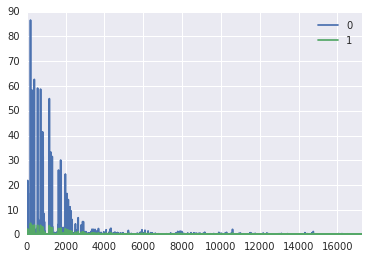

In [30]:
import seaborn as sns
import pandas as pd

d = pd.DataFrame(losses)
# loss,をプロット
sns.set()
d.plot()
plt.show()

In [31]:
testModel(modelS, 'static')

initial State:
[[u'+' u'-' u' ' u'P']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 0; Taking action: d
[[u'+' u'-' u' ' u'P']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 1; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u'P']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 2; Taking action: d
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u'P' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 3; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u'P' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 4; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u' ' u'P' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 5; Taking action: u
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u'P' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 6; Taking action: u
[[u'+' u'-' u' ' u' ']
 [u'P' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Reward: 10


## ランダム版

In [33]:
epsilon = 1.0
epochs = 1000
losses = []

modelR = createModel()
for i in range(epochs):    
    game = Gridworld(mode='random')
    env = SimulationEnv(modelR, game, epsilon)
    done = False
    state = env.state()
    while not done:
        action, Qprob = env.action(state)
        newState, reward, done = env.step(action)
        loss = env.update(state, action, newState, reward, Qprob, done)
        state = newState
        losses.append(loss) 
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

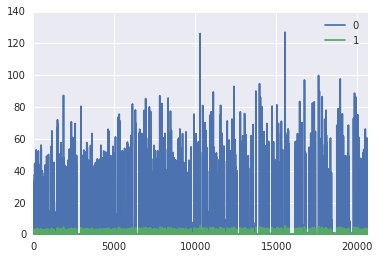

In [34]:
d = pd.DataFrame(losses)
# loss,をプロット
sns.set()
d.plot()
plt.show()

## 経験再現版

### ターゲット・ネットワークの導入

In [11]:
%%writefile models/fig3_10.dot
digraph fig3_10 {
    // 書式を設定
    graph [rankdir=LR, charset="UTF-8"];
    node [shape="box", style="rounded,filled"];
    edge [fontname="ipafont-gothic", lblstyle="auto"];

    Initial_Game_State_St [label="初期ゲーム状態S_t"];
    Q_network [label="Qネットワーク"];
    Q_values [label="Q値"];
    Action_a [label="アクションa"];
    Game_state_St1 [label="ゲーム状態S_t+1"];
    Q_hat_network [label="Qターゲットネットワーク"];
    Q_hat_values [label="Q＾値"];

    Initial_Game_State_St -> Q_network  [label="入力"];
    Q_network -> Q_values [label="予測"];
    Q_values-> Action_a [label="使用されaを得る"];
    Action_a -> Game_state_St1 [label="新しい状態を生成"];
    Game_state_St1 -> Q_network [label="入力"];
    Game_state_St1 -> Q_hat_network;
    Q_hat_network -> Q_hat_values [label="予測"];
    Q_hat_values　-> Q_network [label="学習に使用"];
    Q_hat_network　-> Q_network [label="パラメータを定期的にコピー"];    
 }

Overwriting models/fig3_10.dot


In [12]:
%%bash
dot -Tpng -Gdpi=200 models/fig3_10.dot> images/fig3_10.png

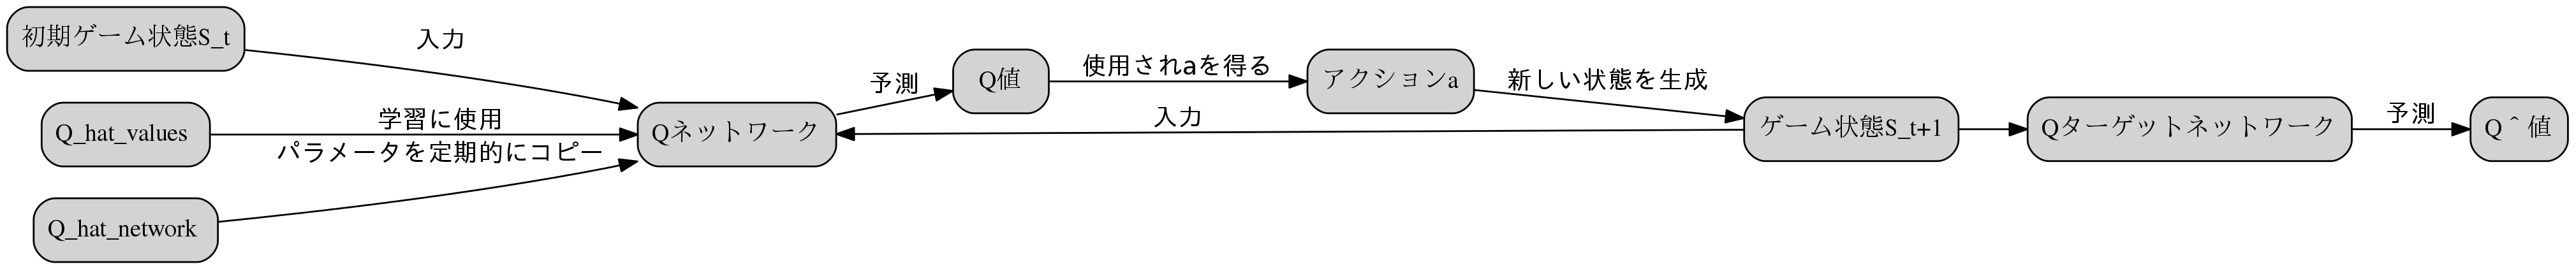

In [13]:
Image("images/fig3_10.png")

In [67]:
from collections import deque

class TargetMemoryEnv(SimulationEnv):
    def __init__(self, model, targetModel, game, epsilon, gamma=0.9, 
                 memorySize = 1200, batchSize = 250, targetUpdateCount=50):
        super(TargetMemoryEnv, self).__init__(model, game, epsilon, gamma=gamma)
        self.memorySize = memorySize
        self.batchSize = batchSize
        self.targetUpdateCount = targetUpdateCount
        self.memory = deque(maxlen=self.memorySize)
        # このターゲットモデルの導入でDeepMindは劇的な収束改善を得た
        self.targetModel = targetModel
        self.replayCount = 0
        
    def remember(self, state, action, reward, newState, done):
        self.memory.append([state, action, reward, newState, done])
        
    def replay(self, losses):
        if len(self.memory) < self.memorySize:
            return
        self.replayCount += 1
        samples = random.sample(self.memory, self.batchSize)
        states = []
        targets = []
        for sample in samples:
            state, action, reward, newState, done = sample
            target = self.targetModel.predict(state)
            if done:
                target[0][action] = reward
            else:
                newQprob = np.max(self.targetModel.predict(newState))
                target[0][action] = reward + self.gamma*newQprob
            states.append(state)
            targets.append(target)
        # リストからnumpyのarrayで、配列並びを(self.batchSize, 64)に変更    
        states = np.array(states).reshape(self.batchSize, 64)
        targets = np.array(targets).reshape(self.batchSize, 4)
        ret = self.model.train_on_batch(states, targets)
        losses.append(ret[0])
        print('\r%d, %f, %f' % (i, ret[0], ret[1]))
        clear_output(wait=True)
            
    def targetUpdate(self):
        if self.replayCount > 0 and (self.replayCount % self.targetUpdateCount) == 0:
            print("Updated")
            weights = self.model.get_weights()
            targetWeights = self.targetModel.get_weights()
            for i in range(len(targetWeights)):
                targetWeights[i] = weights[i]
            self.targetModel.set_weights(targetWeights)

In [77]:
epsilon = 1.0
epochs = 5000
losses = []
changeCount = 50
max_moves = 100

# モデルと環境を生成
modelT = createModel() 
targetModel = createModel() 
game = Gridworld(mode='random')
env = TargetMemoryEnv(modelT, targetModel, game, epsilon)
# エポック数試行する
for i in range(epochs):    
    env.game = Gridworld(mode='random')
    env.epsilon = epsilon
    done = False
    mov = 0
    state = env.state()
    while not done:
        action, Qprob = env.action(state)
        newState, reward, done = env.step(action)
        mov += 1
        env.remember(state, action, reward, newState, done)
        if done or mov > max_moves:
            done = True
        env.replay(losses)
        env.targetUpdate()
        state = newState
        
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

4999, 0.054710, 0.135256


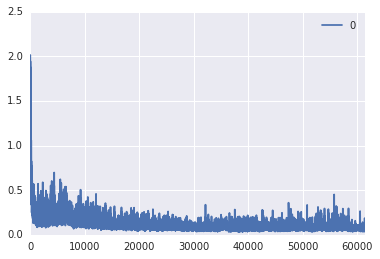

In [78]:
import seaborn as sns
import pandas as pd

d = pd.DataFrame(losses)
# loss,をプロット
sns.set()
d.plot()
plt.show()

In [82]:
testModel(modelT, 'random')

initial State:
[[u' ' u'W' u' ' u' ']
 [u' ' u'+' u' ' u'P']
 [u' ' u' ' u'-' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 0; Taking action: l
[[u' ' u'W' u' ' u' ']
 [u' ' u'+' u' ' u'P']
 [u' ' u' ' u'-' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 1; Taking action: l
[[u' ' u'W' u' ' u' ']
 [u' ' u'+' u'P' u' ']
 [u' ' u' ' u'-' u' ']
 [u' ' u' ' u' ' u' ']]
You won! Reward: 10


True

In [83]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(modelT, 'random', display=False)
    clear_output(wait=True)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 801
Win percentage: 0.801
